# Title: Tuberculosis (TB) Detection from Chest X-ray using CNN and ResNet-50
Domain: Medical Imaging

## Team Name : Terrabythians
### Team Members:
* Nada Latrach
* Yasmine Bahri
* Mohamed Aziz B'chir
* Fatma Naoui
* Nour el Houda Ouni
* Mohamed Aziz Allaya
* Aziz Allah Barkaoui



## Introduction:

### Background
Tuberculosis (TB) remains a major public health concern in Tunisia and globally . Despite efforts to control the disease, Tunisia recorded 2,647 new TB cases in 2021, with the majority (80.4%) affecting individuals aged 15 to 64 years. Extra-pulmonary TB cases have been on the rise, making up 64.6% of cases, with lymph node TB being the most common form (68.5%).

While Tunisia has made progress in reducing TB incidence—from 28 per 100,000 people in 2018 to 22.46 per 100,000 in 2021—regional disparities persist. For instance, the incidence rate in Ariana was 59.3 per 100,000, while it was significantly lower in Monastir at 7.3 per 100,000.

### Goal and Objective
This project aims to develop a TB detection system using ResNet-50 and Convolutional Neural Networks (CNNs) to analyze chest X-ray images. By leveraging a pre-trained model , a custom model and fine-tuning them for TB diagnosis, we seek to enhance accuracy, efficiency, and accessibility in detecting TB.As we are going to evaluate what is the most efficient model ?

### Dataset:
We have used Tuberculosis (TB) Chest X-ray Database to train  and evaluate our model.

#### [Tuberculosis (TB) Chest X-ray Database](https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset)

Tuberculosis (TB) Chest X-ray Database
This dataset was developed by researchers from Qatar University, the University of Dhaka, and medical professionals from Bangladesh and Malaysia. It includes:

* 700 publicly accessible TB-negative chest X-ray images
* 3,500 normal chest X-ray images


#LOAD LIBRARIES

In [ ]:
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense
from tensorflow.keras.optimizers import Adamax



# LOAD DATASETS


We organized the dataset in a directory structure.
```
  - datasets
    |- normal
    |- tuberculosis

```


In [ ]:
# Downloading dataset
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

# unzipping and removing zip file
!unzip tuberculosis-tb-chest-xray-dataset.zip
!rm -rf tuberculosis-tb-chest-xray-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 99% 660M/663M [00:02<00:00, 229MB/s]
100% 663M/663M [00:02<00:00, 252MB/s]
Archive:  tuberculosis-tb-chest-xray-dataset.zip
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflatin

In [ ]:
# Preparing dataset folder and moving the files to it.

!mkdir datasets
!cp -r TB_Chest_Radiography_Database/Normal datasets/normal
!cp -r TB_Chest_Radiography_Database/Tuberculosis datasets/tuberculosis
!rm -rf TB_Chest_Radiography_Database

In [ ]:
# Define dataset paths
dataset_path = "datasets"
normal_path = os.path.join(dataset_path, "normal")
tb_path = os.path.join(dataset_path, "tuberculosis")

# DATA UNDERSTANDING : EDA
In this section, we visualized the distribution of our dataset by plotting a bar graph for , as well as visualizing some images from the dataloader to ensure that they were properly loaded and transformed.

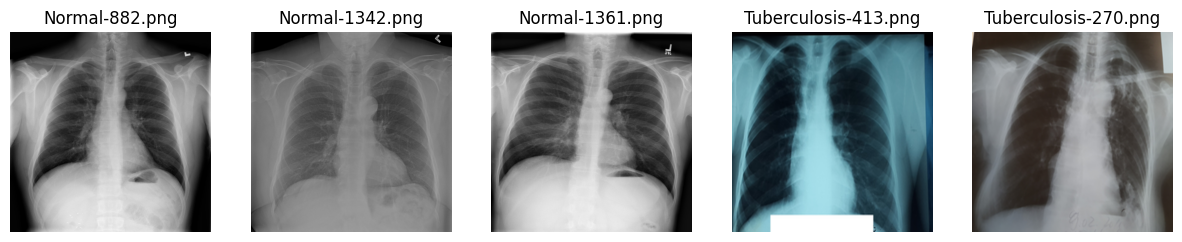

In [ ]:
# Get list of images in the directories
normal_images = os.listdir(normal_path)
tb_images = os.listdir(tb_path)

# Select 5 images from both directories
selected_images = normal_images[:3] + tb_images[:2]

# Display images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for ax, img_name in zip(axes, selected_images):
    img_path = os.path.join(normal_path if img_name in normal_images else tb_path, img_name)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_name)

plt.show()

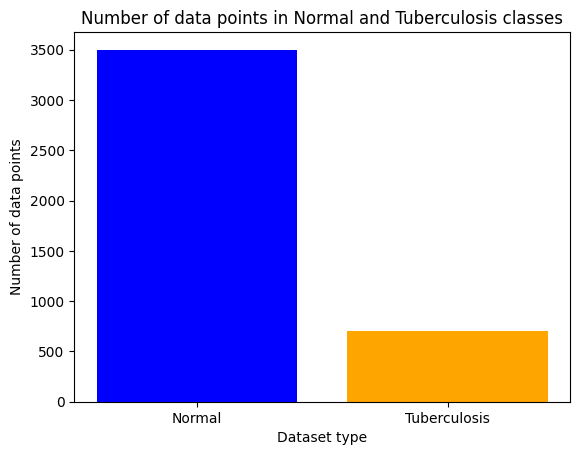

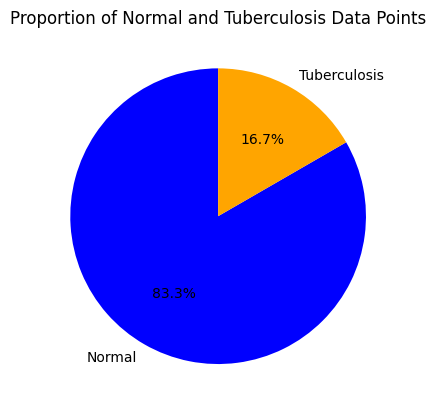

In [ ]:
# Dataset sizes
normal_size = len(os.listdir(normal_path))  # Number of images in Normal folder
tb_size = len(os.listdir(tb_path))  # Number of images in Tuberculosis folder
sizes = [normal_size, tb_size]

# Bar plot
plt.bar(['Normal', 'Tuberculosis'], sizes, color=['blue', 'orange'])

plt.xlabel('Dataset type')
plt.ylabel('Number of data points')
plt.title('Number of data points in Normal and Tuberculosis classes')

# Show the bar plot
plt.show()

# Pie chart
plt.pie(sizes, labels=['Normal', 'Tuberculosis'], colors=['blue', 'orange'], autopct='%1.1f%%', startangle=90)

# Title for pie chart
plt.title('Proportion of Normal and Tuberculosis Data Points')

# Show the pie chart
plt.show()


#### ==> we noticed that the data is imbalanced as we have 83.3% Normal individulas and 16.7% Tuberculosis individuals ,which can lead to overfitting .

==> Therefore , we proceeded with data augmentation in order to balance our dataset

# DATA PREPARATION

## Data augmentation

In [ ]:
!pip install tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array # Import ImageDataGenerator, load_img, and img_to_array
# Define new dataset for augmented images
augmented_tb_path = os.path.join(dataset_path, "tuberculosis_augmented")

# Ensure the new folder exists
os.makedirs(augmented_tb_path, exist_ok=True)

# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Scale pixel values to [0, 1] or we can also normalize
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Get the current number of TB images
tb_images = os.listdir(tb_path)
tb_count = len(tb_images)

# Get the current total number of images
normal_count = len(os.listdir(os.path.join(dataset_path, "normal")))
total_images = normal_count + tb_count

# Calculate target TB count to reach 50%
target_tb_count = int(0.1 * (normal_count + tb_count))
images_needed = target_tb_count - tb_count

# Generate new images until we reach 50% TB
if images_needed > 0:
    print(f"Generating {images_needed} new TB images...")
    generated = 0

    for img_name in tb_images:
        img_path = os.path.join(tb_path, img_name)
        # Check if it's a file before processing
        if os.path.isfile(img_path):
            img = load_img(img_path)  # Load image
            img_array = img_to_array(img)  # Convert to array
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Generate and save images
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augmented_tb_path, save_prefix="aug", save_format="png"):
                i += 1
                generated += 1
                if generated >= images_needed:
                    break  # Stop once we reach the required number

print(f"Augmentation complete! TB images now make up at least 40% of the dataset.")

Augmentation complete! TB images now make up at least 40% of the dataset.


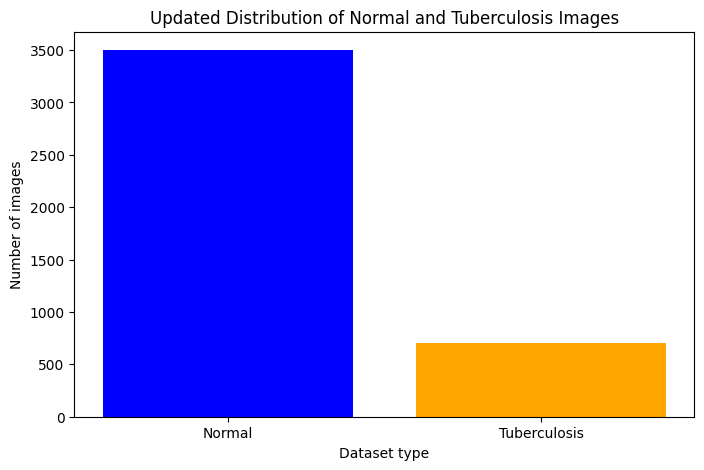

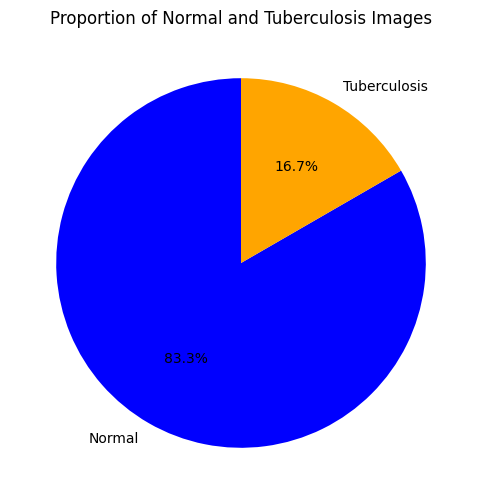

In [ ]:
# Count images in each category
normal_size = len(os.listdir(normal_path))  # Normal images
tb_size = len(os.listdir(tb_path)) + len(os.listdir(augmented_tb_path))  # Original TB + Augmented TB

# Sizes for visualization
sizes = [normal_size, tb_size]
labels = ['Normal', 'Tuberculosis']

# Bar plot
plt.figure(figsize=(8, 5))
plt.bar(labels, sizes, color=['blue', 'orange'])
plt.xlabel('Dataset type')
plt.ylabel('Number of images')
plt.title('Updated Distribution of Normal and Tuberculosis Images')
plt.show()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=['blue', 'orange'], autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Normal and Tuberculosis Images')
plt.show()


#### ==> Then , we proceeded by dividing the dataset into training, validation and test sets in order to properly train and evaluate our models. This division of dataset is done to ensure that the model is trained on one set of data, validated on another and finally tested on unseen data to evaluate the performance.

##Split the datasets

In [ ]:
from sklearn.model_selection import train_test_split # Import the necessary function
#Get the list of image paths for each category
normal_images = [os.path.join(normal_path, fname) for fname in os.listdir(normal_path)]
tb_images = [os.path.join(tb_path, fname) for fname in os.listdir(tb_path)]
augmented_tb_images = [os.path.join(augmented_tb_path, fname) for fname in os.listdir(augmented_tb_path)]

# Merge the datasets
all_images = normal_images + tb_images + augmented_tb_images

# Create corresponding labels for the images
labels = ['Normal'] * len(normal_images) + ['Tuberculosis'] * len(tb_images) + ['Tuberculosis'] * len(augmented_tb_images)

# Shuffle the data
shuffled_data = list(zip(all_images, labels))
random.shuffle(shuffled_data)
shuffled_images, shuffled_labels = zip(*shuffled_data)

# Split the data into train and test sets (80% train, 20% test)
train_images, test_images, train_labels, test_labels = train_test_split(
    shuffled_images, shuffled_labels, test_size=0.2, random_state=42
)

# Now you have train and test data
print(f"Training data: {len(train_images)} images")
print(f"Test data: {len(test_images)} images")

# Now you can use train_images and test_images for training and testing

Training data: 3360 images
Test data: 840 images


In [ ]:
# Split train data into features (X) and labels (y)
x_train = list(train_images)
y_train = list(train_labels)

# Split test data into features (X) and labels (y)
x_test = list(test_images)
y_test = list(test_labels)

# Print the dataset sizes
print(f"Training set: {len(x_train)} images, {len(y_train)} labels")
print(f"Test set: {len(x_test)} images, {len(y_test)} labels")

Training set: 3360 images, 3360 labels
Test set: 840 images, 840 labels


##Z-score normalization

In [ ]:
import os
import cv2
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define target size (224x224 for model)
TARGET_SIZE = (224, 224)

def preprocess_images(image_paths):
    images = []

    for path in image_paths:
        # Check if it's a file before processing
        if os.path.isfile(path):
            img = load_img(path, target_size=TARGET_SIZE)  # Load image
            img_array = img_to_array(img)  # Convert to array (float32 format)
            images.append(img_array)

    images = np.array(images, dtype=np.float32)  # Convert list to NumPy array
    images /= 255.0  # Normalize pixel values to [0,1]

    return images

# Preprocess train, validation, and test images
train_images_array = preprocess_images(train_images)
test_images_array = preprocess_images(test_images)

# Print mean and standard deviation before standardization
print("Before Standardization:")
print("Train Mean:", train_images_array.mean(), "Train Std:", train_images_array.std())

# Apply Standardization (Z-score normalization)
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images_array.reshape(len(train_images_array), -1)).reshape(train_images_array.shape)
test_images_scaled = scaler.transform(test_images_array.reshape(len(test_images_array), -1)).reshape(test_images_array.shape)

# Print mean and standard deviation after standardization
print("After Standardization:")
print("Train Mean:", train_images_scaled.mean(), "Train Std:", train_images_scaled.std())

Before Standardization:
Train Mean: 0.50812453 Train Std: 0.26003116
After Standardization:
Train Mean: 2.62496e-09 Train Std: 1.0000004


#MODELING

###Version1

#### Build a CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  # Input shape matches preprocessed images
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(2, activation='softmax'))  # Output layer with 2 neurons and softmax activation

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,218 (42.61 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

##Set the loss and objectives

In [ ]:
# Compile the model
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

In [ ]:
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.preprocessing import LabelEncoder

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 5 )
label_encoder = LabelEncoder()

# Fit the encoder to your labels and transform them into numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now use y_train_encoded in model.fit
history = model.fit(
    train_images_scaled,
    y_train_encoded,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es]
)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.8473 - loss: 0.9426 - val_accuracy: 0.9598 - val_loss: 0.1187
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9627 - loss: 0.1133 - val_accuracy: 0.9554 - val_loss: 0.1064
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9766 - loss: 0.0887 - val_accuracy: 0.9821 - val_loss: 0.0671
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9821 - loss: 0.0644 - val_accuracy: 0.9896 - val_loss: 0.0334
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9840 - loss: 0.0510 - val_accuracy: 0.9762 - val_loss: 0.0535
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9921 - loss: 0.0251 - val_accuracy: 0.9836 - val_loss: 0.0380
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9877 - loss: 0.0353 - val_accuracy: 0.9911 - val_loss: 0.0203
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9887 - loss: 0.0361 - val_accuracy: 0.9896 - 

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,507,656 (127.82 MB)

 Trainable params: 11,169,218 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,438 (85.21 MB)

## Set some metrics to track the progress of the training

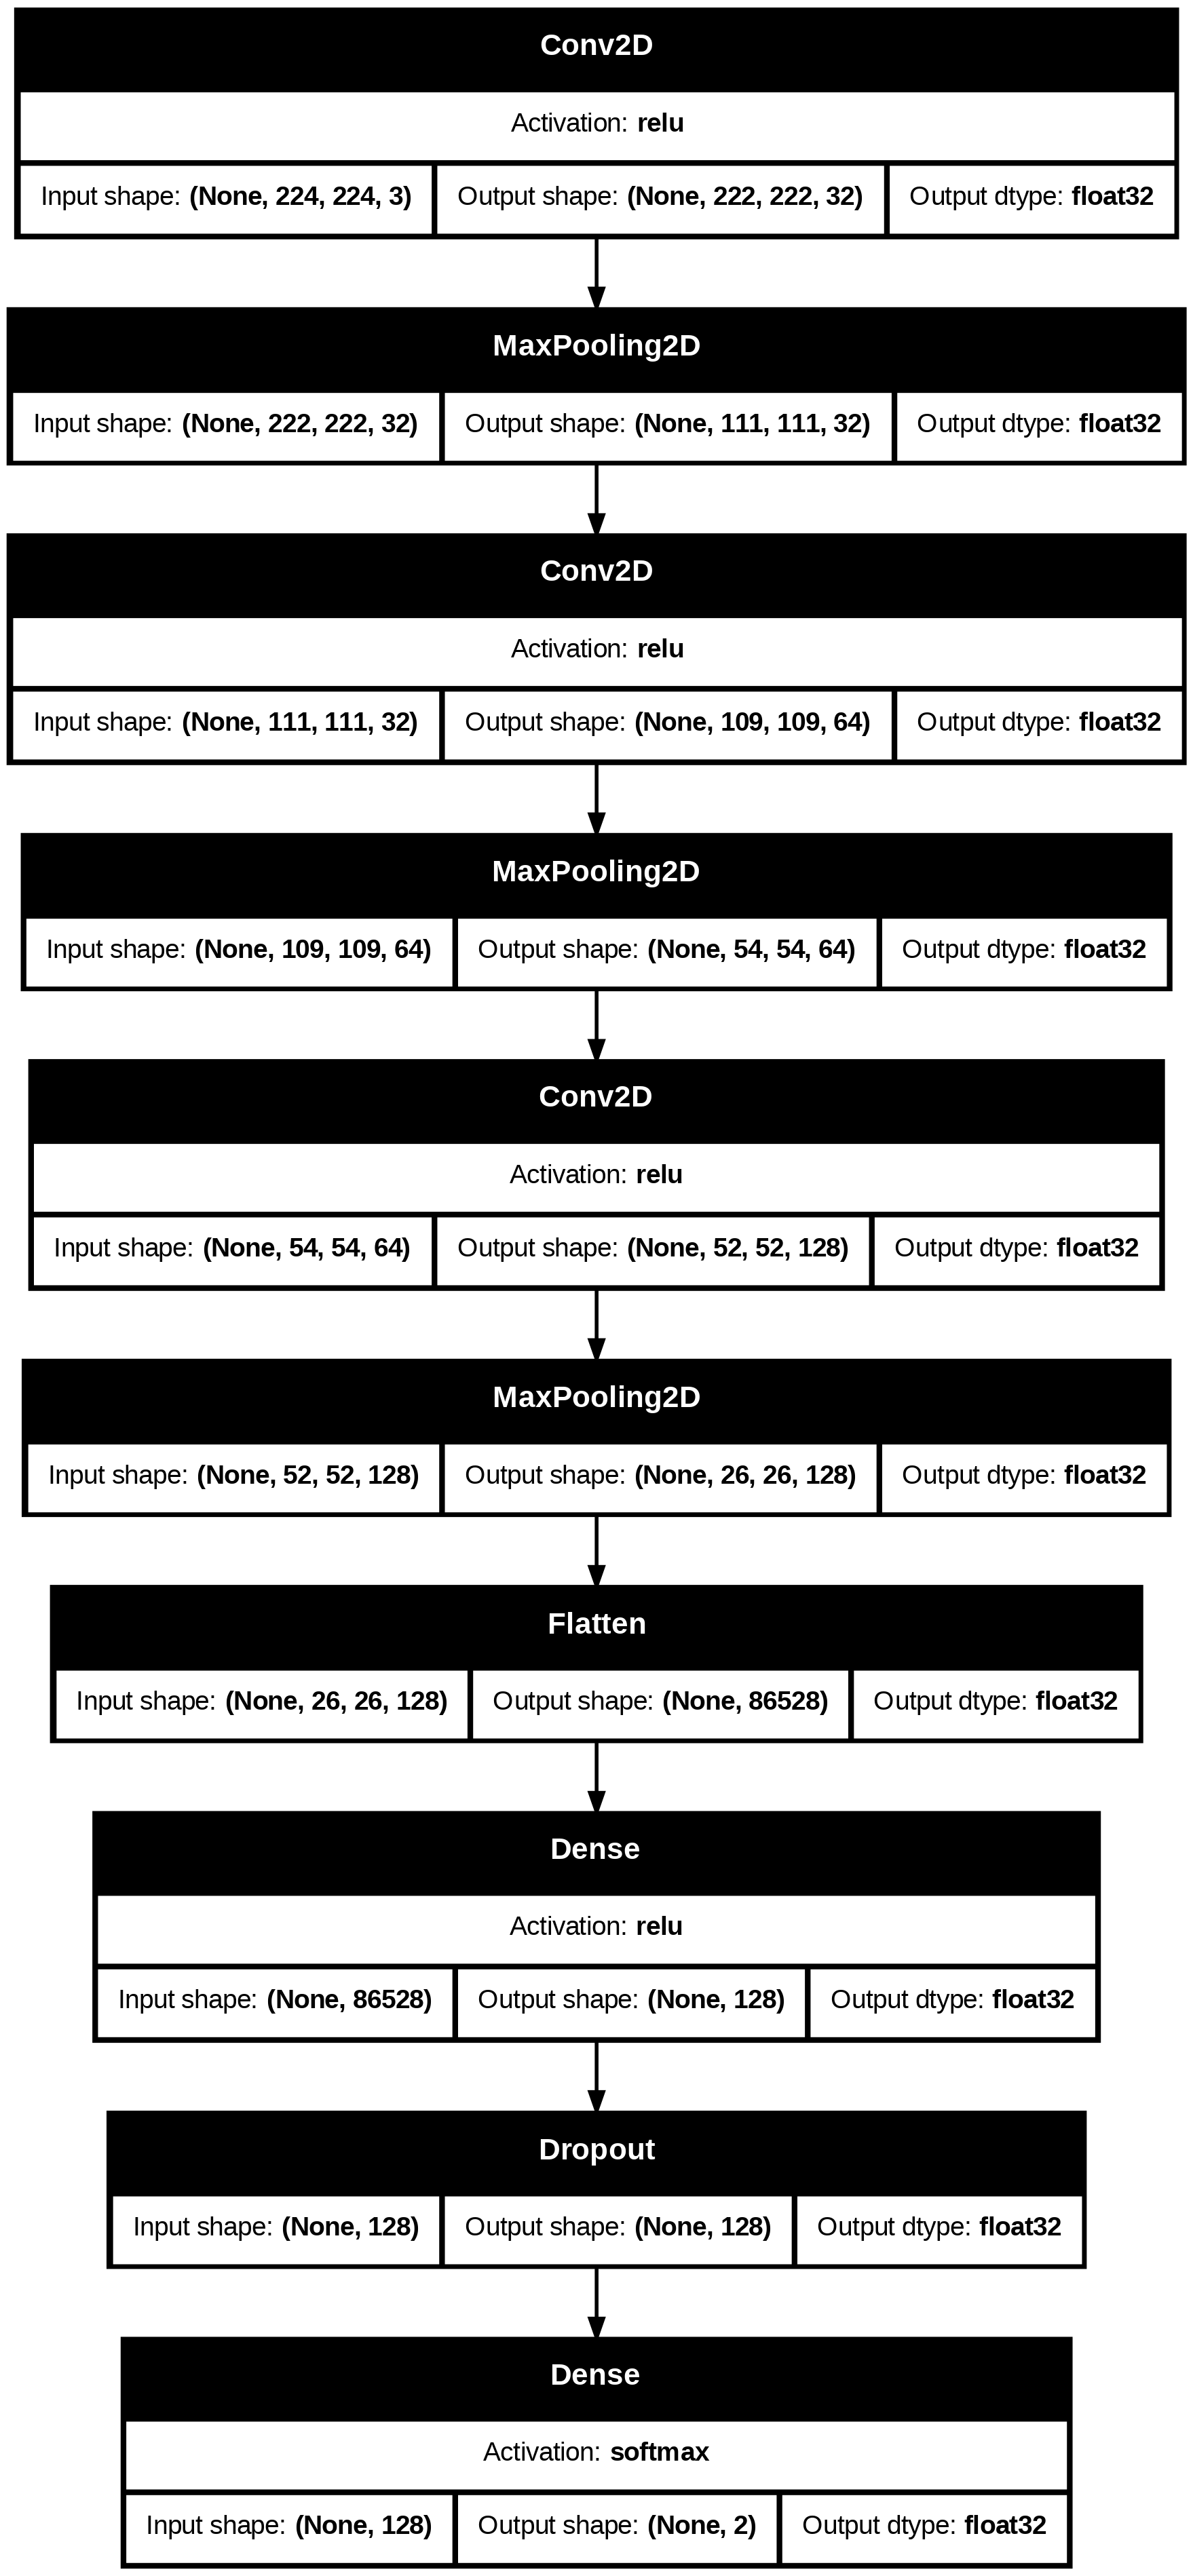

In [ ]:
tf.keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

# MODEL EVALUATION

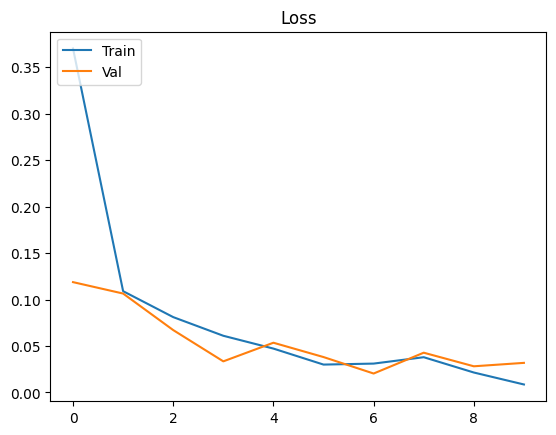

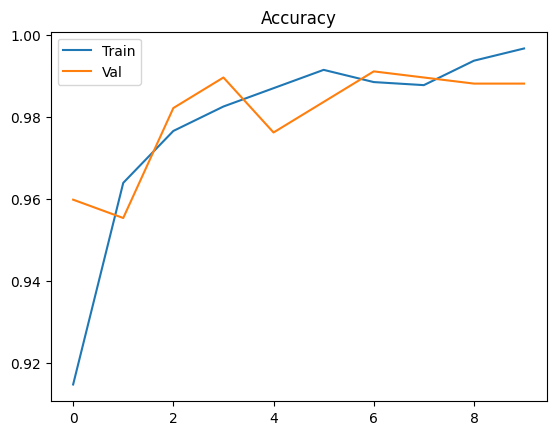

In [ ]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

In [ ]:
loss, acc = model.evaluate(test_images_scaled, y_test_encoded)
print("Test loss", loss)
print("Test accuracy", acc)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9877 - loss: 0.0441
Test loss 0.02366258017718792
Test accuracy 0.9928571581840515


### Version 2

#### Build a CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  # Input shape matches preprocessed images
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))





model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(2, activation='sigmoid'))  # Output layer with 2 neurons and softmax activation

# Compile the model with SGD optimizer
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,207,362 (12.24 MB)

 Trainable params: 3,207,362 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

### what if we add a convolutional layer and the activation fucntion and the optimizer used ?
what did we notice ?

##Set the loss and objectives




In [ ]:
# Compile the model
from tensorflow.keras.optimizers import SGD

opt = SGD(learning_rate=0.01)
model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.preprocessing import LabelEncoder

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 5 )
label_encoder = LabelEncoder()

# Fit the encoder to your labels and transform them into numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now use y_train_encoded in model.fit
history = model.fit(
    train_images_scaled,
    y_train_encoded,
    epochs=12,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es]
)

Epoch 1/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.8310 - loss: 0.4494 - val_accuracy: 0.8824 - val_loss: 0.2750
Epoch 2/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.9126 - loss: 0.2428 - val_accuracy: 0.9315 - val_loss: 0.1866
Epoch 3/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9342 - loss: 0.1980 - val_accuracy: 0.9524 - val_loss: 0.1473
Epoch 4/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.9390 - loss: 0.1734 - val_accuracy: 0.9479 - val_loss: 0.1341
Epoch 5/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.9478 - loss: 0.1408 - val_accuracy: 0.9360 - val_loss: 0.1514
Epoch 6/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9602 - loss: 0.1187 - val_accuracy: 0.9568 - val_loss: 0.1175
Epoch 7/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9644 - loss: 0.1266 - val_accuracy: 0.9494 - val_loss: 0.1238
Epoch 8/12
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9639 - loss: 0.1153 - val_accuracy: 0.95

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,207,364 (12.24 MB)

 Trainable params: 3,207,362 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Set some metrics to track the progress of the training

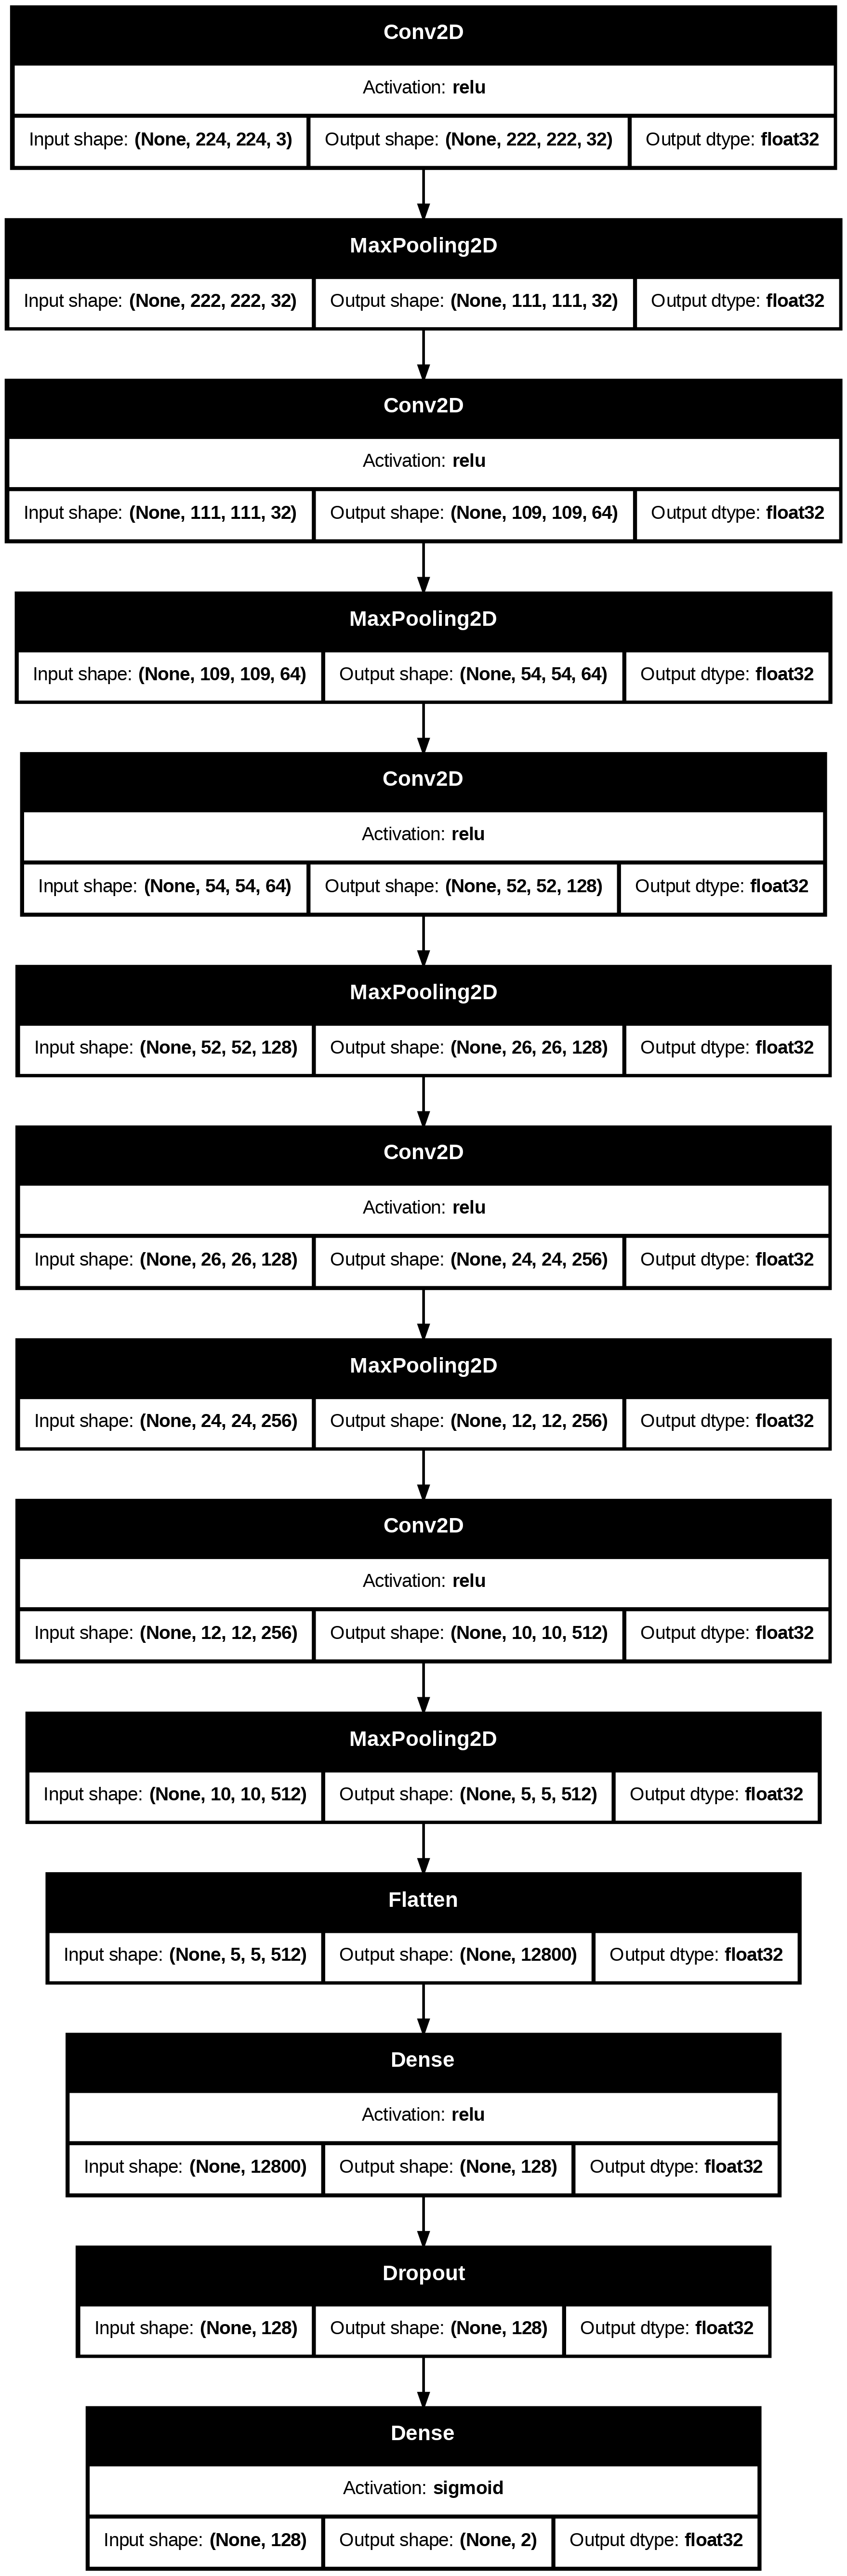

In [ ]:
tf.keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

# MODEL EVALUATION

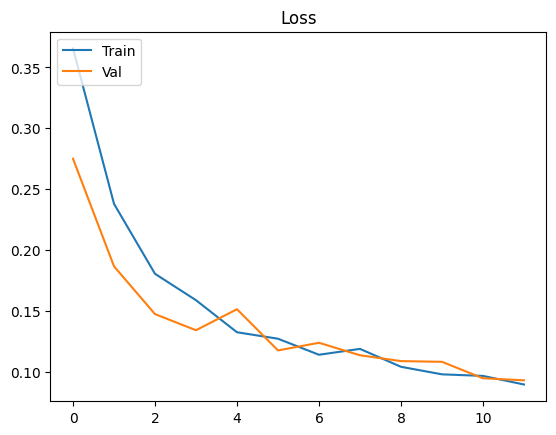

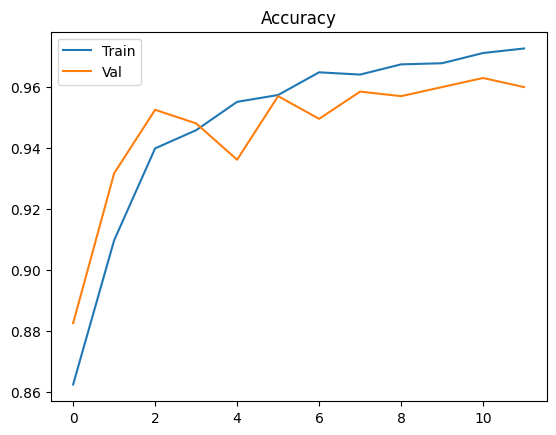

In [ ]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

In [ ]:
loss, acc = model.evaluate(test_images_scaled, y_test_encoded)
print("Test loss", loss)
print("Test accuracy", acc)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9600 - loss: 0.1061
Test loss 0.08126780390739441
Test accuracy 0.9714285731315613


### Version 3

#### Build a CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, Input
from tensorflow.keras.optimizers import RMSprop

# Define the CNN model
model = Sequential()

# Input layer
model.add(Input(shape=(224, 224, 3)))

# Convolutional layers
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(LeakyReLU(negative_slope=0.1))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(LeakyReLU(negative_slope=0.1))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(negative_slope=0.1))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(negative_slope=0.1))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(negative_slope=0.1))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same'))  # 6th Conv Layer
model.add(LeakyReLU(negative_slope=0.1))

model.add(Conv2D(512, (1, 1), padding='same'))  # 7th Conv Layer (1x1 kernel to avoid shrinking)
model.add(LeakyReLU(negative_slope=0.1))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU(negative_slope=0.1))
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(2, activation='softmax'))  # Output layer with 2 neurons

# Compile the model with RMSprop optimizer (learning rate = 0.0005)
model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 7, 7, 512)           │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 10,614,338 (40.49 MB)

 Trainable params: 10,614,338 (40.49 MB)

 Non-trainable params: 0 (0.00 B)

##Set the loss and objectives

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# Define the optimizer with a modified learning rate
opt = RMSprop(learning_rate=0.0005)

# Compile the model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)


In [ ]:
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn.preprocessing import LabelEncoder

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience = 5 )
label_encoder = LabelEncoder()

# Fit the encoder to your labels and transform them into numerical values
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Now use y_train_encoded in model.fit
history = model.fit(
    train_images_scaled,
    y_train_encoded,
    epochs=11,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es]
)

Epoch 1/11
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - accuracy: 0.8246 - loss: 0.6819 - val_accuracy: 0.8185 - val_loss: 8.3253
Epoch 2/11
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.9482 - loss: 0.4564 - val_accuracy: 0.9792 - val_loss: 0.0702
Epoch 3/11
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9769 - loss: 0.0715 - val_accuracy: 0.9821 - val_loss: 0.0443
Epoch 4/11
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9859 - loss: 0.0357 - val_accuracy: 0.9435 - val_loss: 0.1740
Epoch 5/11
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9791 - loss: 0.0586 - val_accuracy: 0.9911 - val_loss: 0.0424
Epoch 6/11
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.9912 - loss: 0.0338 - val_accuracy: 0.9911 - val_loss: 0.0288
Epoch 7/11
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.9948 - loss: 0.0179 - val_accuracy: 0.9926 - val_loss: 0.0227
Epoch 8/11
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9971 - loss: 0.0140 - val_accuracy: 0.99

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 7, 7, 512)           │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,228,678 (80.98 MB)

 Trainable params: 10,614,338 (40.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,614,340 (40.49 MB)

## Set some metrics to track the progress of the training

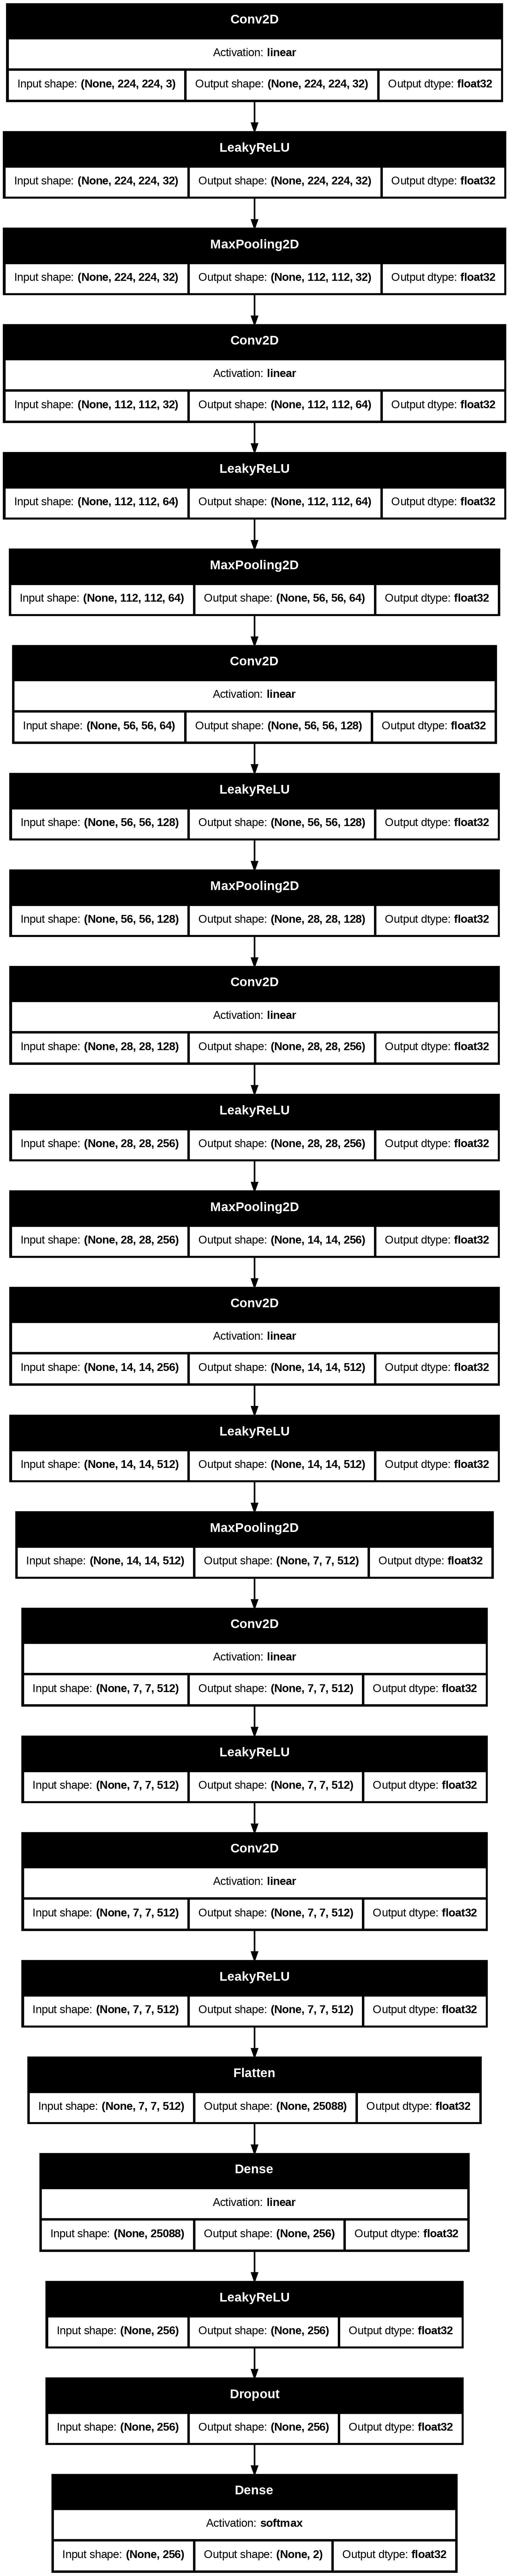

In [ ]:
tf.keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

# MODEL EVALUATION

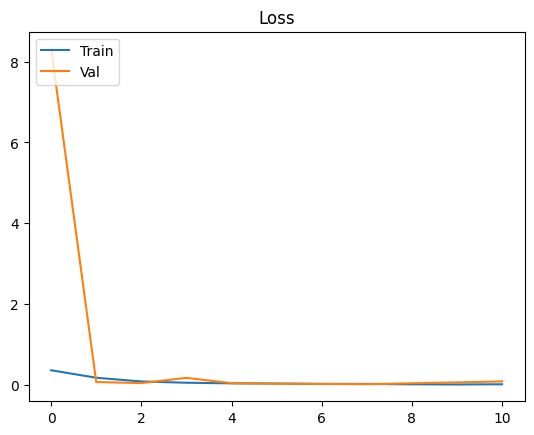

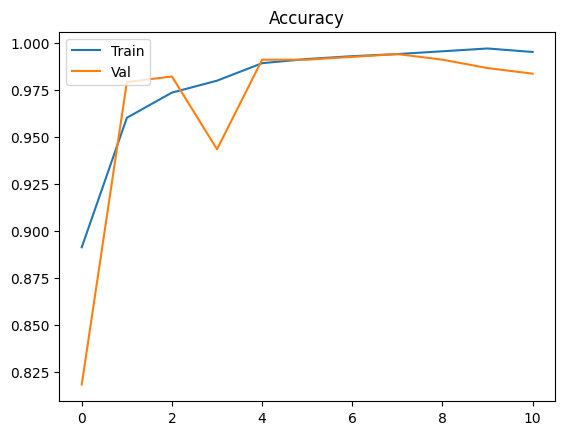

In [ ]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

In [ ]:
loss, acc = model.evaluate(test_images_scaled, y_test_encoded)
print("Test loss", loss)
print("Test accuracy", acc)

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.9759 - loss: 0.1875
Test loss 0.11301016807556152
Test accuracy 0.9857142567634583


## Pre-trained model

# 1. Model Selection & Justification

**ResNet-50** is chosen for its deep architecture with residual connections, preventing vanishing gradients.

**Pretrained** on ImageNet, making it suitable for transfer learning in medical imaging.

**Outperforms VGG** heavier, no residuals.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# 2. Implementation & Fine-Tuning


**Preprocessing:** Resize images to 224×224.

**Architecture Modifications:**
Remove ResNet-50’s top layer.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



Add Global Average Pooling → Dense (ReLU) → Dense (Softmax).


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(2, activation='softmax')(x)  # Output layer with 2 neurons for your classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

**Training Strategy:**

**Stage 1:** Freeze ResNet layers, train only the new classifier.

**Stage 2:** Unfreeze last 10–20 layers, fine-tune with low LR.
.


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

**Optimizer:** Adam

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_images_scaled, y_train_encoded, epochs=10, validation_data=(test_images_scaled, y_test_encoded))

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 223ms/step - accuracy: 0.8127 - loss: 0.6765 - val_accuracy: 0.9464 - val_loss: 0.1327
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.9577 - loss: 0.1177 - val_accuracy: 0.9417 - val_loss: 0.1507
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9551 - loss: 0.1181 - val_accuracy: 0.9679 - val_loss: 0.0824
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9668 - loss: 0.0834 - val_accuracy: 0.9607 - val_loss: 0.0883
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.9710 - loss: 0.0666 - val_accuracy: 0.9571 - val_loss: 0.1140
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.9744 - loss: 0.0606 - val_accuracy: 0.9357 - val_loss: 0.1565
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9657 - loss: 0.0783 - val_accuracy: 0.9786 - val_loss: 0.0683
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.9886 - loss: 0

**Loss Function:** Categorical Cross-Entropy

In [ ]:
model.summary()

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 29,888,392 (114.02 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,200,454 (16.02 MB)

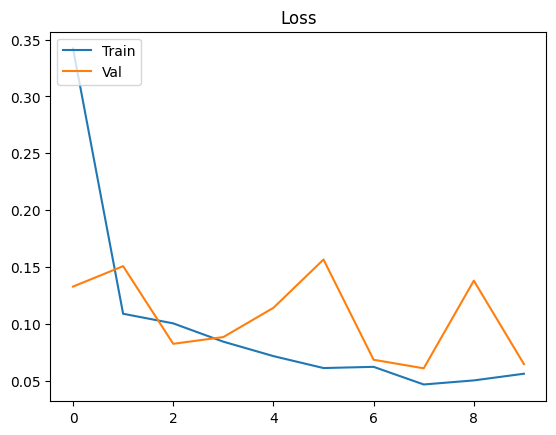

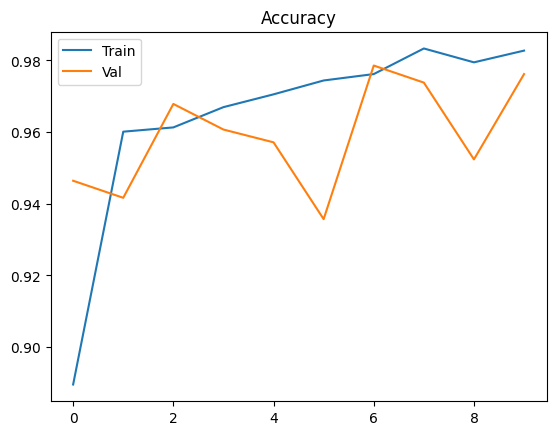

In [ ]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

In [ ]:
loss, acc = model.evaluate(test_images_scaled, y_test_encoded)
print("Test loss", loss)
print("Test accuracy", acc)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9731 - loss: 0.0618
Test loss 0.06453143060207367
Test accuracy 0.976190447807312
